# Clustering

## Outline

In our last notebook JML we had our first encounter with Julia and learned how to manipulate arrays and generate simple graphics. The main objectives of today's lab are to:
- Explore the use of KLD 
- Gain more understanding of k-means, Fuzzy C-Means, and EM

## Part 1. KL divergence
Here we use KLD to review our metrics lecture and look at whether it makes a proper "metric". 
We give two forms of the implementation of KLD - choose your preferred style: 

In [1]:
function divg_KL(p::Array{Float64}, q::Array{Float64})
    dim = length(p)
    kld = 0
    for i in 1:dim
        kld += p[i]*log(p[i]/q[i])
    end
    kld
end

divg_KL (generic function with 1 method)

In [2]:
function divg_KL(p::Array{Float64}, q::Array{Float64})
    sum(p .* log.(p ./ q))
end

divg_KL (generic function with 1 method)

The results from the following two cells clearly indicate that KLD is *not* symmetric:

In [3]:
divg_KL([0.1, 0.9], [0.8, 0.2])

1.1457255029306632

In [4]:
divg_KL([0.8, 0.2], [0.1, 0.9])

1.3627377539886139

**Task 1**: Carry out a similar experiment and show that KLD does not satisfy triangular inequality either:

In [5]:
# code for Task 1
p1 = [0.8, 0.2]
p2 = [0.5, 0.5]
p3 = [0.1, 0.9]
divg_KL(p1, p2) + divg_KL(p2, p3) > divg_KL(p1, p3)

false

Sometimes our histograms have zero entries. Run the following code - there is a problem!

In [6]:
divg_KL([1.0, 0.0], [0.99, 0.01])

NaN

This is because it makes no sense to do log(0) (and division by 0). As a work-around, we carry out so-called Laplace correction, assigning a very very small value to the zero entries and renormalize it (so that it remains a summed-to-1 histogram), as explained below.

Suppose the histogram is $[p_1, p_2, ..., p_n]$, then adding $\epsilon$ to each element, making it become
$[p_1+\epsilon, p_2+\epsilon, \cdots, p_n+\epsilon]$. The sum of all entries now becomes 
$$ p_1+p_2+\cdots+p_n+n\epsilon=1+n\epsilon$$
For normalization, we need to divide every $p_i$ by $1+n\epsilon$. 

**Task 2**: Write a function that does Laplacian correction to a histogram with zero entries. Apply the KLD to the corrected histograms using the failed example given above.

In [7]:
function lapl_corr(p::Array{Float64}; ϵ=1.0e-10)
    (p .+ ϵ)/(1.0 + length(p)*ϵ)
end

lapl_corr (generic function with 1 method)

In [8]:
lapl_corr([1.0, 0.0]; ϵ=1.0e-10)

2-element Vector{Float64}:
 0.9999999999
 9.999999998e-11

In [9]:
divg_KL(lapl_corr([1.0, 0.0]), lapl_corr([0.99, 0.01]))

0.010050334009418306

The "Distances.jl" package has a "kl_divergence()" function. The newest version now does a good job: 

In [10]:
using Distances
kl_divergence([1.0, 0.0], [0.99, 0.01])

0.010050335853501506

## Part 2 - Clustering
### Preparing data

We begin with the simple k-means demo written in Julia, with some graphics to help. 

In [11]:
using Plots

In [12]:
b1 = randn(100)  
b2 = randn(100) .+ 20.0;

Let's plot out their histograms - they do seem "normal":

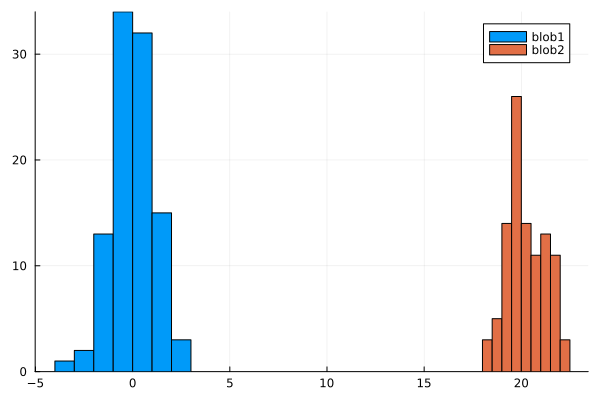

In [13]:
histogram(b1, label="blob1", bins=10)
histogram!(b2, label="blob2", bins=10)

We then concatenate the two data blobs (as two column vectors) *vertically*, which gives us a new column vector (with 200 entries):

In [14]:
d = vcat(b1, b2)  # vertical concatenation

200-element Vector{Float64}:
  0.39342104035492087
 -3.656572972459023
  0.5286719464338544
 -0.29417784155813276
 -0.9498224015742275
  2.8763121893417
 -1.5417184433122058
 -0.6703255730513388
 -0.03726671662459087
  2.4550161742551215
  1.356150247287632
  1.1798846178890776
 -0.23108598895459143
  ⋮
 21.957170511646414
 19.227057059867537
 18.960192934653943
 20.80874473636698
 21.826341205866417
 21.066214738128075
 21.00095222752786
 20.6401234009851
 20.117604426493884
 21.431750292041123
 19.800812681031843
 19.802257701146285

... and we shuffle the rows to get the data mixed up (not actually required for k-means but it just makes the data look more natural;0))

In [15]:
using Random
shuffle!(d)  # now d got shuffled

200-element Vector{Float64}:
 20.017241136860417
 19.227057059867537
 19.92285184609661
 18.838528770471722
 19.289759943205706
 21.066214738128075
 -1.26177055918285
  0.735640043598484
 20.384191026627217
 -0.7360360182981567
  0.028623368237606365
  0.29995408413323754
 -0.12781468339787427
  ⋮
 20.27931530478411
  0.8166840737225877
 -1.6700612359612317
 19.047134912959937
 20.007226081455048
 -0.3745459571998751
 -0.46439586169560915
 21.12918859517383
 19.96751899149699
 -0.041126849894759177
  0.32151597190762454
 19.800812681031843

Let's put these lines into a function for generating some random, 1-d data.

In [16]:
function gen_1d_data(offset=20.0)
    b1 = randn(100) 
    b2 = randn(100) .+ offset
    data = vcat(b1, b2)
    shuffle!(data)
end

gen_1d_data (generic function with 2 methods)

In [17]:
data = gen_1d_data()

200-element Vector{Float64}:
  0.12823228860231112
 20.103314135844222
 20.551143300840057
 18.395742550871695
 21.59165541798377
  1.5091822560489376
 -0.22031134495309326
 -1.0989117861043516
  2.1909279164493958
 -0.13422131584311553
  1.7935018483163312
 22.079949785975813
 -0.46722063073886805
  ⋮
 18.235564495697705
 -0.7210741748256635
  1.2616367135990993
 20.561023033339104
 -0.3994065807382604
 -1.9996985125585927
 19.574432356282344
 -0.21452756159736516
  0.5099303057639598
 18.430618930163664
  0.27241729176729584
 20.697326283501074

### Clustering in action

Let's now try clustering the data into two clusters using k-means. A simple treatment is to randomly initialise the membership for Cluster 1 (and therefore for Cluster 2)

In [18]:
memb1 = rand([0,1], length(data)) # in k-means, membership is either 1 or 0
memb2 = 1 .- memb1    # membership to Cluster 2
## now we can get the cluster centres
c1 = sum(data .* memb1) / sum(memb1)
c2 = sum(data .* memb2) / sum(memb2)
println("c1=", c1, "\tc2=", c2) 

c1=8.87276382421178	c2=10.85437554823279


The two initial centres seem to be in wrong place for now. Let's see how the k-means iterations may make a difference: update centres; update membership; repeat... we run 10 iterations:

In [19]:
## Iterate for a number of times and see if convergence is reached. 
## c1 and c2 are the two cluster centres. 
## This updates the centres, then membership, and loops around
for i in 1:10
    # update centres
    c1 = sum(data .* memb1) / sum(memb1)
    c2 = sum(data .* memb2) / sum(memb2)
    # if distance to c1 is smaller it belongs to cluster 1, memb1=1; otherwise memb1=0
    memb1 = (abs.(data .- c1) .< abs.(data .- c2))
    memb2 = 1 .- memb1
    println("C1 =", c1, "\tC2 =", c2) # print out cluster centres
end 

C1 =8.87276382421178	C2 =10.85437554823279
C1 =-0.12449281391344036	C2 =19.91108053807864
C1 =-0.12449281391344036	C2 =19.91108053807864
C1 =-0.12449281391344036	C2 =19.91108053807864
C1 =-0.12449281391344036	C2 =19.91108053807864
C1 =-0.12449281391344036	C2 =19.91108053807864
C1 =-0.12449281391344036	C2 =19.91108053807864
C1 =-0.12449281391344036	C2 =19.91108053807864
C1 =-0.12449281391344036	C2 =19.91108053807864
C1 =-0.12449281391344036	C2 =19.91108053807864


In [20]:
#import Pkg; Pkg.add("StatsPlots")
using StatsPlots

Now we display the data distributions (using the original d1/d2) and the cluster centres:

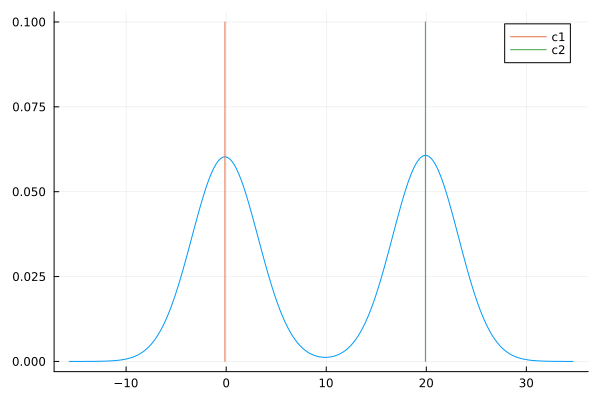

In [21]:
#density([b1, b2], label=["b1" "b2"])
density(data, label="")
plot!([c1, c1], [0, 0.1], label="c1")
plot!([c2, c2], [0, 0.1], label="c2")

Does the algorithm seem to work? Explain. 

**Answer**: Yes it seems to work well, with new centres located around the "theoretical" values of 0.0 and 20.0.


**Task 3:** Suppose there is an outlier data point, data[80]=100.0. Repeat the experiement above and comment on the results.  

In [22]:
olddatum = data[80]
data[80]=100.0
for i in 1:10
    # update centres
    c1 = sum(data .* memb1) / sum(memb1)
    c2 = sum(data .* memb2) / sum(memb2)
    # if distance to c1 is smaller it belongs to cluster 1, memb1=1; otherwise memb1=0
    memb1 = (abs.(data .- c1) .< abs.(data .- c2))
    memb2 = 1 .- memb1
    println("C1 =", c1, "\tC2 =", c2) # print out cluster centres
end 

C1 =0.8703351507675421	C2 =19.91108053807864
C1 =-0.13097459518430077	C2 =20.704040136711527
C1 =-0.13097459518430077	C2 =20.704040136711527
C1 =-0.13097459518430077	C2 =20.704040136711527
C1 =-0.13097459518430077	C2 =20.704040136711527
C1 =-0.13097459518430077	C2 =20.704040136711527
C1 =-0.13097459518430077	C2 =20.704040136711527
C1 =-0.13097459518430077	C2 =20.704040136711527
C1 =-0.13097459518430077	C2 =20.704040136711527
C1 =-0.13097459518430077	C2 =20.704040136711527


**Comments:**
The outlier has surely impacted the clustering outcome, shifting the 2nd cluster centre to the right (from 20.1 to 20.9). The first cluster centre maintained the same location. 

**Task 4:** Carry out the clustering experiment using the fuzzy c-means scheme with r=2 given below. Explain the use of "eps". Does fuzzy c-means work better?

In [23]:
# fuzzy c-means (FCM)
#data[80] = olddatum
function fcmeans(data, r=2)
    memb1 = rand([0.0, 1.0], length(data)) 
    memb2 = 1 .- memb1
    eps=1e-20
    ## Iterate for a number of times and see if convergence is reached. 
    ## c1 and c2 are the two cluster centres. 
    ## This updates the centres, then membership, and loops around
    for it in 1:20
        c1 = sum(data .* memb1) / sum(memb1)
        c2 = sum(data .* memb2) / sum(memb2)
        memb1 = (data .- c1 .+ eps).^(-2.0) ./ ((data .- c1 .+ eps).^(-2.0) .+ (data .- c2 .+ eps).^(-2.0)) 
        #memb1 = (data .- c1).^(-2.0)/((data .- c1).^(-2.0) .+ (data .- c2).^(-2.0)) 
        memb2 = 1.0 .- memb1
        println(c1, "\t", c2)
    end
end

data[80] = 100.0
#println("Outcome with a 9.0 outlier")
#fcmeans(data)
#data[80] = 100.0
#println("Outcome with a 100.0 outlier")
fcmeans(data)

11.490690387122093	9.375339343470165
12.45695114348775	8.272751652830301
14.31737458433995	6.30645701376227
17.10889997541861	3.3333773079621274
19.562652964776856	0.9192624594556221
20.287043114189736	0.3287649279805181
20.342625183734206	0.318656777193928
20.34394046647762	0.3206626969527578
20.34387867758377	0.3207504368314491
20.34387404591728	0.3207492740388198
20.343874019562126	0.3207490608349947
20.34387402797649	0.3207490562571774
20.343874028301727	0.3207490565355403
20.34387402829542	0.320749056553715
20.343874028294568	0.3207490565537468
20.34387402829455	0.3207490565537115
20.343874028294554	0.32074905655370994
20.343874028294554	0.3207490565537102
20.343874028294554	0.3207490565537102
20.343874028294554	0.3207490565537102


**Comments:** 
The extra variable "eps" in the code is to deal with potential division-by-0 overflow which happens when the data point is of zero distance to a cluster centre - so it does the same kind of Laplace correction as in Part 1's KLD calculation. 

FCM uses soft membership, which in theory could give better immunity to noise, but obviously this is rather limited. Note in FCM it does not use any parameter to control the compactness of a cluster (as in GEM). Rather, reciprocols of squared distance-to-centre are weighted to produce the soft membership assigning a data point to the centres. So a large distance-to-centre does not mean the membership will be small, because normalization is involved. If both to-the-centre distances are small, then the memberships to both clusters remain significant! Let's look at what happens with our data point "100.0":

In [24]:
(100.0-20.)^2/((100.0-20.)^2 + (100.0-0.)^2)  # membership to cluster 1

0.3902439024390244

So, while both centres are rather far away from the outlier, it leads to a roughly 40/60 membership split. As a result, the outlier is used to tune both centres, resulted in significant drifts from their "normal" positions. To an extent, one may even prefer k-means with crisp membership (0/1) in this situation, as only one cluster centre would be compromised by the outlier. 

To sum up, FCM may help to produce better vector quantization prototypes, but as we have seen its ability to deal with outliers is certainly not satisfactory. Indeed, it may be a better idea to just remove outliers *before* carrying out clustering. Next, we turn to another clustering approach that can handle "noises". 


P.S. How the outlier affects the clusters is the key point here, so we expected you to comment on this in the lab work.

## Part 3 - DBSCAN and clustering evalution

### DBSCAN

Let's experiment with another clustering algoithm and take a quick look of clustering evaluation. For these tasks we use the "Clustering" and "Distances" packages:

In [25]:
# import Pkg; Pkg.add("Clustering")
using Clustering
# import Pkg; Pkg.add("Distances")
using Distances

Let's generate some data and plot a scatter plot:

In [26]:
function make_blobs(centers, n; std = 0.4, random_state=0)
    X = centers[:, 1] .+ std * randn(2, n)
    nc = size(centers)[2]
    for i in 2:nc
        X = hcat(X, centers[:, i] .+ std * randn(2, n))
    end
    X
end

make_blobs (generic function with 1 method)

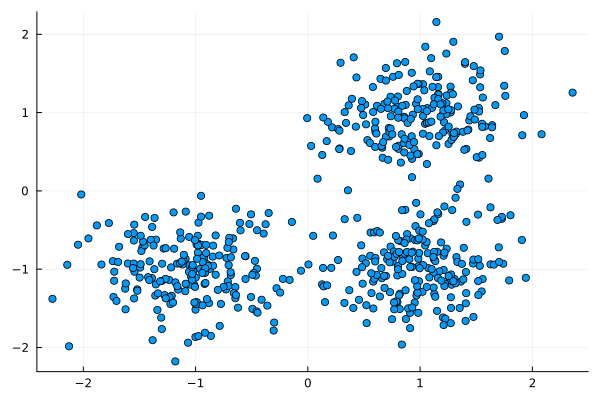

In [27]:
centers = [[1, 1] [-1, -1] [1, -1]]
Random.seed!(0)
X = make_blobs(centers, 200)
scatter(X[1,:], X[2,:], label="")

The DBSCAN algorithm works by classifying data points into core/border vs noise points. The following code uses Distances' pairwise() function to generate a NxN matrix (N is the total number of points, 600 in this case), and the dbscan() function uses to derive the clusters. Note we have Eps=0.3, MinPts=10:

(Or Eps=0.4, MinPts=100; settings dependent on number of samples generated...)

In [28]:
dists = pairwise(SqEuclidean(), X);
db_res = dbscan(dists, 0.2, 30);
println("no. of clusters:", nclusters(db_res))

no. of clusters:3


The actual assignments (we call it "membership" in lectures) looks a little different, because the "noise" points get assigned to a "0" cluster:

In [29]:
sort(unique(assignments(db_res)))  # print out sorted, unique cluster membership

4-element Vector{Int64}:
 0
 1
 2
 3

The counts() method gives the counts per cluster for clusters 1-3:

In [30]:
counts(db_res) 

3-element Vector{Int64}:
 210
 212
 207

**Task 5**: Write a function that takes the DBSCAN result and the data as inputs, and generates a scatter plot, with each cluster's points shown in different colour, and the noise data points in black. 

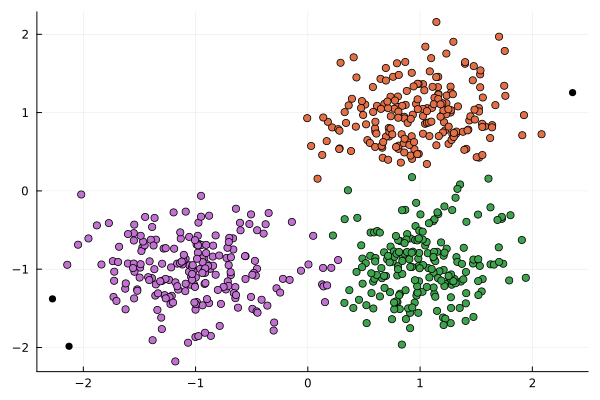

In [31]:
# plot DBSCAN results
function plot_dbscan_result(db_res, X)
    p = plot()
    #assignments(clusters)
    memb = assignments(db_res)
    for clu_id in sort(unique(memb))
        set = (memb .== clu_id) 
        if clu_id == 0
            p = scatter!(X[1, set], X[2, set], label="", c=:black)
        else
            p = scatter!(X[1, set], X[2, set], label="")
        end
    end
    p
end

plot_dbscan_result(db_res, X)

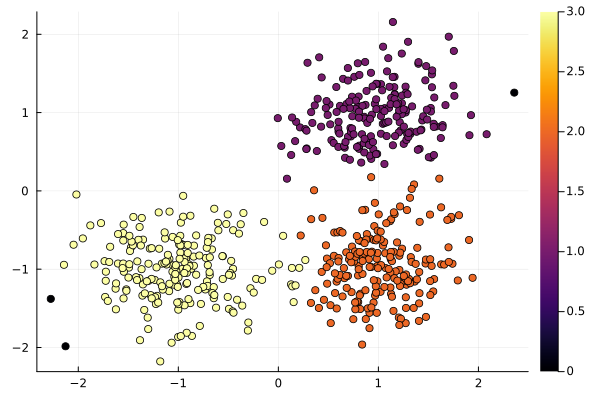

In [32]:
# A simpler method from Tomo (and others?) "0" happens to give the black by default
scatter(X[1, :], X[2, :], marker_z = assignments(db_res), label="")

*Some more reflection*

How to decide the distance threshold Eps, and then the MinPts parameter? \
Our solution remains largely empirical, but we may get some rough ideas about a possible range if we plot out the estimated probability density of the pairwise distances of all data points. The density peaks at around 0.2-0.5, meaning that many local neighbours are within that distance from each other. There is also a dent at 2.0, indicating the gap between border points of different cluster.   

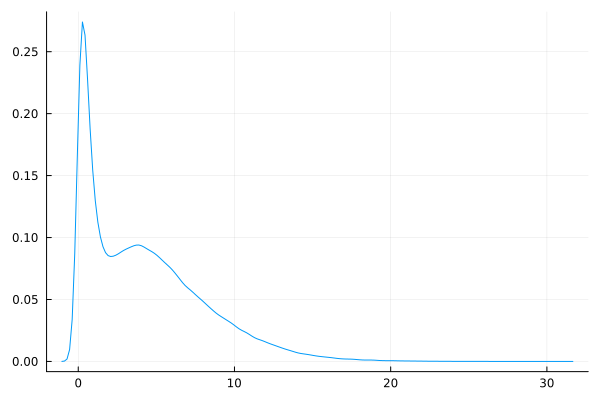

In [33]:
density(vec(dists), bins=20, label="")

### Cluster validation
Let's use the Silhouette Coefficients for cluster validation. To use the mean() function later we start by using Statistics:

In [34]:
using Statistics

You might have noticed that although 3 clusters are reported, there are actually four clusters "labels"

In [35]:
sum(assignments(db_res).==0)

3

In [36]:
X_clu = X[:, assignments(db_res).!=0]
dists2 = pairwise(SqEuclidean(), X_clu);

In [37]:
memb = assignments(db_res)
mean(silhouettes(memb[memb.!=0], dists2))

0.8109869067572549

In [38]:
memb = assignments(db_res) .+ 1
mean(silhouettes(memb, dists))

0.8023371919776097

In [39]:
sc = silhouettes(memb, dists)
mean(sc[memb .!= 1])

0.8107324800021293

In [40]:
median(silhouettes(memb, dists))

0.870975561346415

In [41]:
for eps in [0.05, 0.11, 0.16, 0.21, 0.25]
    db_res = dbscan(dists, eps, 30);
    X_clu = X[:, assignments(db_res).!=0]
    if length(X_clu) == 0
        continue
    end
    dists_clu = pairwise(SqEuclidean(), X_clu);
    memb = assignments(db_res)
    print("Eps=", eps, "\tNC:", nclusters(db_res))
    if nclusters(db_res) > 1  # with 1 cluster we can't calculate SC
        print("\tavgSC=", mean(silhouettes(memb[memb.!=0], dists_clu)))
    end
    println()
end

Eps=0.05	NC:3	avgSC=0.9351919767250787
Eps=0.11	NC:3	avgSC=0.8440537203757202
Eps=0.16	NC:3	avgSC=0.815320071447564
Eps=0.21	NC:3	avgSC=0.8124151087753869
Eps=0.25	NC:1


In [42]:
for minpts in [3, 5, 10, 20, 30, 40, 50]
    db_res = dbscan(dists, 0.06, minpts);
    X_clu = X[:, assignments(db_res).!=0]
    if length(X_clu) == 0
        continue
    end
    dists_clu = pairwise(SqEuclidean(), X_clu);
    memb = assignments(db_res)
    print("MinPts=", minpts, "\tNC:", nclusters(db_res))
    if nclusters(db_res) > 1
        print("\tavgSC=", mean(silhouettes(memb[memb.!=0], dists_clu)))
    end
    println()
end

MinPts=3	NC:3	avgSC=0.19240859106449112
MinPts=5	NC:3	avgSC=0.19523716278537462
MinPts=10	NC:3	avgSC=0.85022233824835
MinPts=20	NC:3	avgSC=0.8827338302001714
MinPts=30	NC:3	avgSC=0.90201659814937
MinPts=40	NC:2	avgSC=0.9411380656320739


### Evaluation of k-means clustering

**Task 6:** Generate a [run chart](https://www.pqsystems.com/qualityadvisor/DataAnalysisTools/run_chart.php) that displays the trend of average Silhouette Coefficients versus k, for k in 2:10. 

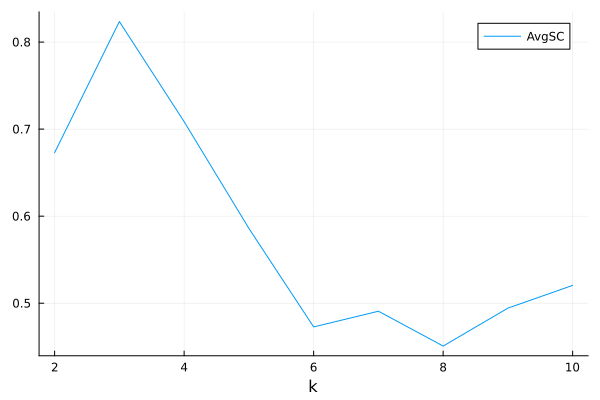

In [43]:
# plot of SC vs k
scs =[]
for k in 2:10
    R = kmeans(X, k; maxiter=200)
    memb = assignments(R)
    push!(scs, mean(silhouettes(memb, dists)))
end
plot(2:10, scs, label="AvgSC", xlabel="k")

### **Comments:**

When k (number of clusters specified for k-means) increases from 2 to 10 (yes I tried a bigger range) it is interesting to see that the Silhouette Coefficient quickly climbs high, then drops. Note it is not a steady trend but with small fluctuations (k=6, and 9). The best score goes to k=3 (0.83), which is consistent with the DBSCAN result, and how we generated the data in the first place!